# Phylogenetic visualization using QIIME2 and phyloseq

Here, I explore the bacterial content of 4 geothermal hot springs in the Spirea Creek area of Yellowstone National Park. Samples were collected in July 2017 and stored within the GEOPIG (Group Exploring Organic Processes in Geochemistry) Lab at Arizona State University. DNA was extracted and amplified using qPCR and the sequences were shipped off to be sequenced using 16S Illumina Amplicon Protocol and the 515F/806R primer pair.

In this notebook, we will first import and denoise the raw fastq files in ```QIIME 2```. Next, we will generate a feature table, various diversity metrics, and a rooted phylogenetic tree for subsequent generation of a ```phyloseq``` object and importation into R. Finally, we will explore the taxonomic data, generating phylogenetic trees and bar plots.

**Note that this notebook is a work in progress and analyses are ongoing.**


### The springs

Four distinct hot springs in the previously uncharacterized Spirea Creek area were sampled and named Heart of Joy, Hat Stew, Green Machine, and Bubble Boy. At first glance, Hat Stew stood out considerably, being the only spring which was lacking obvious photosynthetic pigments. Instead, the inner surface was a cream color, fringed by orange. Hat Stew was measured at 47°C and a pH of 7.9, but displayed no obvious signs of photosynthesis: a strange observation for this temperature and pH regime. On the other hand, Heart of Joy, Green Machine, and Bubble Boy were visibly photosynthetic. 

We'll now read in our metadata, which includes environmental chemistry data including the pH, temperature, and some other geochemical variables for the hot springs which the microbial samples were taken.

In [1]:
spirea_metadata <- read.table('spirea-metadata2.tsv')

header.true <- function(df) {
  names(df) <- as.character(unlist(df[1,]))
  df[-1,]
}

spirea_metadata <- header.true(spirea_metadata)
spirea_metadata

,sampleID,SiteName,pH,temp,year,elevation,DIC(ppmC),DOC(ppmC),DO(mg/L),NO2-(ppm),NO3-(ppm),Na+(ppm),NH4+(ppm)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,112M,HoJ,7.7,43.9,2017,2172,98,0.94,3.4,0,0.00064,242.39,0.016
3,113M,HatStew,7.9,47.1,2017,2172,95,0.53,2.8,0.011,0.071,247.11,0.0044
4,114M,GreenMachine,6.7,66.7,2017,2181,106,0.67,0.6,0.00041,0.0037,238.98,0.051
5,115M,BubbleBoy,7.1,62.2,2017,2179,100,0.67,1.4,0.00091,0.02,239.85,0.024


### Importing the data
This microbiome sequence data is in Casava 1.8 demultiplexed (paired-end) format. As such, there are 2 fastq.gz files for each sample: the forward and reverse reads.
```
qiime tools import \
	--type 'SampleData[PairedEndSequencesWithQuality]' \
	--input-path 'Raw_data/spirea_M' \
	--input-format CasavaOneEightSingleLanePerSampleDirFmt \
	--output-path 'q2_output/spireaM-demux-paired-end.qza'
```

### Denoising the sequences using DADA2
The ```dada2 denoise-paired``` function denoises paired-end sequences, dereplicates them, and filters chimeras. This will output several critical artifact files, including our representative sequences, feature table, and denoising statistics. After inspecting the QC scores of the sequences using FastQC, I decided to truncate the forward reads at position 235 and the reverse reads at 200.

```
qiime dada2 denoise-paired \
  --i-demultiplexed-seqs q2_output/spireaM-demux-paired-end.qza \
  --p-trunc-len-f 235 \
  --p-trunc-len-r 200 \
  --p-trim-left-f 0 \
  --p-trim-left-r 0 \
  --o-representative-sequences q2_output/rep-seqs-spireaM.qza \
  --o-table q2_output/table-spireaM.qza \
  --o-denoising-stats q2_output/stats-spireaM.qza
```

### Feature classification
The ```feature-classifier classify-sklearn``` function classifies reads by taxon using a specific classifier. In this case, the classifier is a pre-trained Naive Bayes classifier, trained on the Greengenes 13_8 99% OTUs, wherein the sequences have been trimmed to only include 250 bases from the V4 region (bound by the 515F/806R primer pair) of the 16S rRNA gene.

```
qiime feature-classifier classify-sklearn \
  --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
  --i-reads q2_output/rep-seqs-spireaM.qza \
  --o-classification q2_output/taxonomy-spireaM.qza

qiime metadata tabulate \
  --m-input-file q2_output/taxonomy-spireaM.qza \
  --o-visualization q2_output/taxonomy-spireaM.qzv
```

### Generating a tree for phylogenetic diversity analyses
Computing diversity measures such as Shannon Diversity, Faith's Phylogenetic Diversity, Bray-Curtis distance, and weighted UniFrac requires a rooted phylogenetic tree which relates features to one another. To generate a phylogenetic tree we will use ```align-to-tree-mafft-fasttree``` pipeline from the ```q2-phylogeny``` plugin to align our sequences and subsequently generate a rooted and unrooted tree.
```
qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences q2_output/rep-seqs-spireaM.qza \
  --o-alignment q2_output/aligned-rep-seqs-spireaM.qza \
  --o-masked-alignment q2_output/masked-aligned-rep-seqs.qza \
  --o-tree q2_output/unrooted-tree.qza \
  --o-rooted-tree q2_output/rooted-tree.qza
```

### Alpha and beta diversity analyses
We’ll first apply the core-metrics-phylogenetic method, which rarefies our feature table to a user-specified depth, computes several alpha and beta diversity metrics, and generates principle coordinates analysis (PCoA) plots using Emperor for each of the beta diversity metrics. The metrics computed by default are:

**Alpha diversity**

- Shannon’s diversity index (a quantitative measure of community richness)
- Observed Features (a qualitative measure of community richness)
- Faith’s Phylogenetic Diversity (a qualitiative measure of community richness that incorporates phylogenetic relationships between the features)
- Evenness (or Pielou’s Evenness; a measure of community evenness)

**Beta diversity**

- Jaccard distance (a qualitative measure of community dissimilarity)
- Bray-Curtis distance (a quantitative measure of community dissimilarity)
- unweighted UniFrac distance (a qualitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)
- weighted UniFrac distance (a quantitative measure of community dissimilarity that incorporates phylogenetic relationships between the features)

```
qiime diversity core-metrics-phylogenetic \
  --i-phylogeny q2_output/rooted-tree-spireaM.qza \
  --i-table q2_output/table-spireaM.qza \
  --p-sampling-depth 2812 \
  --m-metadata-file spirea-metadata.txt \
  --output-dir core-metrics-results
```

### Generating bar plots

```
qiime taxa barplot \
  --i-table q2_output/table-spireaM.qza \
  --i-taxonomy q2_output/taxonomy-spireaM.qza \
  --m-metadata-file spirea-metadata.txt \
  --o-visualization q2_output/taxa-bar-plots-spireaM.qzv
```

### Import bioinformatic packages

qiime2R (https://rdrr.io/github/jbisanz/qiime2R/f/README.md) is a package developed for importing QIIME 2 artifact files (.qza) into R, returning data in forms that are simpler to process.

In [2]:
library(qiime2R)
library(phyloseq)
library(ggplot2)

Warning message:
“package ‘phyloseq’ was built under R version 4.0.3”


For example, the ```read_qza``` function will read an OTU table into a dataframe.

In [3]:
OTUs <- read_qza("table.qza")
OTUs$data[1:5,1:5]

,L1S105,L1S140,L1S208,L1S257,L1S281
4b5eeb300368260019c1fbc7a3c718fc,2183,0,0,0,0
fe30ff0f71a38a39cf1717ec2be3a2fc,5,0,0,0,0
d29fe3c70564fc0f69f2c03e0d1e5561,0,0,0,0,0
868528ca947bc57b69ffdf83e6b73bae,0,2249,2117,1191,1737
154709e160e8cada6bfb21115acc80f5,802,1174,694,406,242


The ```qza_to_phyloseq``` function inputs multiple artifact files to produce a ```phyloseq``` object.

In [4]:
#qza_to_phyloseq(features, tree, taxonomy, metadata, tmp)

In [5]:
features = '/Users/dgagler/School/BIOINFORMATICS/spirea_creek/q2_output/table-spireaM.qza'
tree = '/Users/dgagler/School/BIOINFORMATICS/spirea_creek/q2_output/rooted-tree-spireaM.qza'
taxonomy = '/Users/dgagler/School/BIOINFORMATICS/spirea_creek/q2_output/taxonomy-spireaM.qza'
metadata = '/Users/dgagler/School/BIOINFORMATICS/spirea_creek/spirea-metadata.txt'
tmp = '/Users/dgagler/School/BIOINFORMATICS/spirea_creek/phyloseq'

In [6]:
spirea <- suppressMessages(qza_to_phyloseq(features, tree, taxonomy, metadata, tmp))

Now that we've created our phyloseq object, we'll explore some basic features of the data.

In [7]:
ntaxa(spirea)
nsamples(spirea)
sample_names(spirea)
sample_sums(spirea)

[1] 585

[1] 4

[1] "112M" "113M" "114M" "115M"

112M  113M  114M  115M 
 9184  2812 13804 13026

We can import our taxonomy artifact using the ```read_qza``` function and follow it with the ```parse_taxonomy``` function to return a dataframe whereby the rows are feature IDs and columns are taxonomic levels.

In [8]:
taxonomy_df <- read_qza(taxonomy)
taxonomy_df <- parse_taxonomy(taxonomy_df$data)
head(taxonomy_df)

,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
13c21b13ee04dfa73f153435ade94443,Bacteria,Chloroflexi,Chloroflexi,Chloroflexales,Chloroflexaceae,NA,NA
51acce8b357887fe262b1510bdab29d5,Bacteria,Chloroflexi,Anaerolineae,SBR1031,A4b,NA,NA
7a949ff26d0a4bf30d6018167145c58e,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,coagulans
eee9b44702eec90685b5eaea8b930536,Bacteria,NA,NA,NA,NA,NA,NA
46d09eb4ca7faf08d233c2974947437e,Bacteria,Proteobacteria,Deltaproteobacteria,Thermodesulfobacteriales,NA,NA,NA
fcec09c05f195da578d3a945a074da97,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,NA


A good way to explore the diversity of our samples is using The ```plot_richness``` function, which estimates various alpha diversity metrics and visualizes them using ggplot.

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


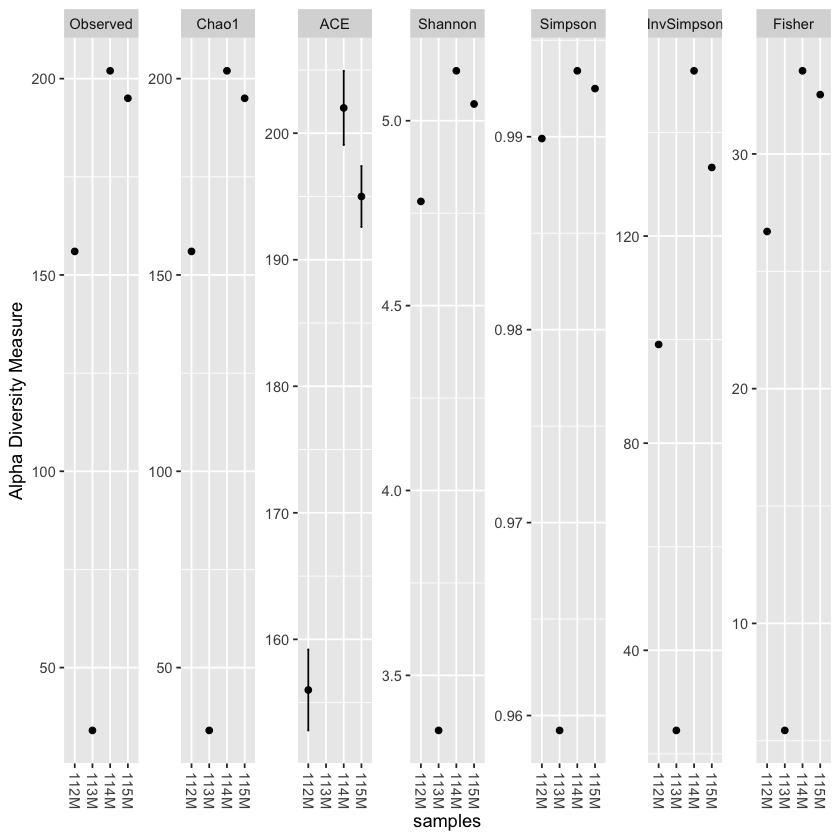

In [9]:
plot_richness(spirea)

**Figure 1.** Alpha diversity estimations for the dataset. Sample 113M (Hat Stew) is consistently and significantly lower in these alpha diversity measures than the other 3 samples. Samples 114M and 115M exhibit very similar diversity measures.

We can also use the ```plot_tree``` function to visualize the phylogeny of our samples.

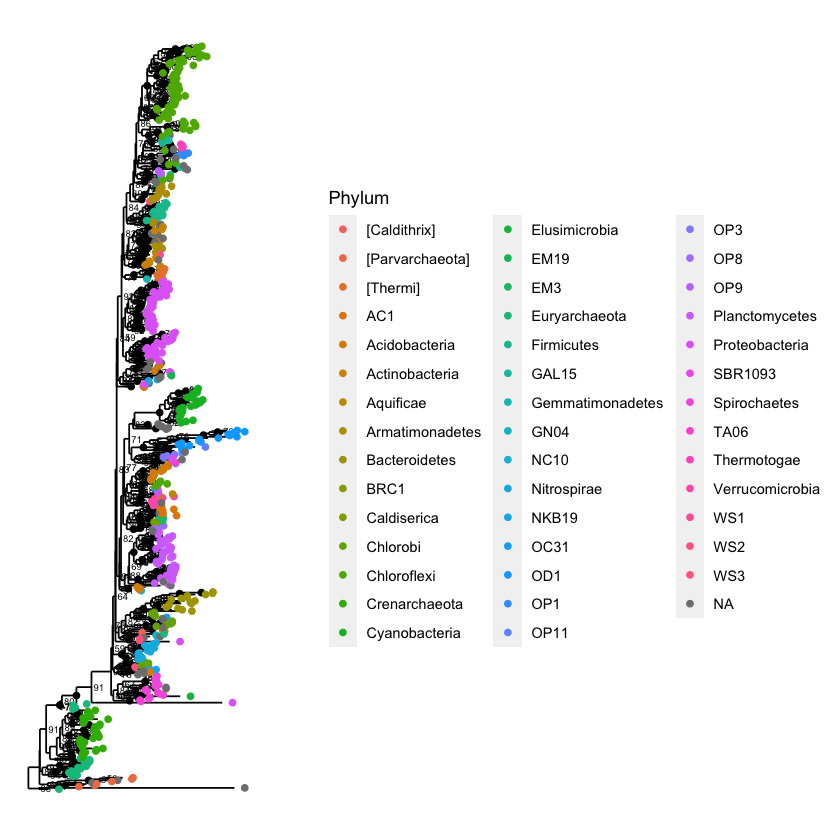

In [10]:
suppressWarnings(plot_tree(spirea, nodelabf=nodeplotboot(), ladderize="left", color="Phylum", base.spacing = 0.05))

**Figure 2.** Phylogenetic tree made from our ```phyloseq``` object. Nodes are colored according to Phylum. Note that there are significnat clusters of Actinabacteria, Bacteroidetes, Chlorobi, Chloroflexi, Firmicutes, and Proteobacteria. Note that the node identified as NA is evolutionarily distant from the other taxa in our samples. This suggests the presence of novel microbes or a blind spot in our taxonomic classifier.

We can also investigate the contents of specific taxonomic levels in our dataset using the ```get_taxa_unique``` function.

In [11]:
get_taxa_unique(spirea, "Phylum")

[1] "Euryarchaeota"    NA                 "[Parvarchaeota]"  "Crenarchaeota"   
 [5] "Proteobacteria"   "Spirochaetes"     "Elusimicrobia"    "Acidobacteria"   
 [9] "NKB19"            "WS3"              "Chlorobi"         "Nitrospirae"     
[13] "GN04"             "Bacteroidetes"    "OC31"             "Firmicutes"      
[17] "Actinobacteria"   "BRC1"             "[Caldithrix]"     "NC10"            
[21] "Caldiserica"      "EM3"              "AC1"              "OP8"             
[25] "Verrucomicrobia"  "Chloroflexi"      "Aquificae"        "OD1"             
[29] "OP11"             "OP3"              "TA06"             "Cyanobacteria"   
[33] "Planctomycetes"   "EM19"             "SBR1093"          "Gemmatimonadetes"
[37] "[Thermi]"         "Armatimonadetes"  "WS1"              "WS2"             
[41] "OP1"              "Thermotogae"      "GAL15"            "OP9"

Perhaps we are interested the phylogenetic trees of certain phyla, such as the Firmicutes or Proteobacteria, which feature prominently in this data. This can be achieved by using the ```subset_taxa``` and ```plot_tree``` functions.

In [12]:
firmicutes <- suppressMessages(subset_taxa(spirea, Phylum == "Firmicutes"))
proteobacteria <- suppressMessages(subset_taxa(spirea, Phylum == "Proteobacteria"))

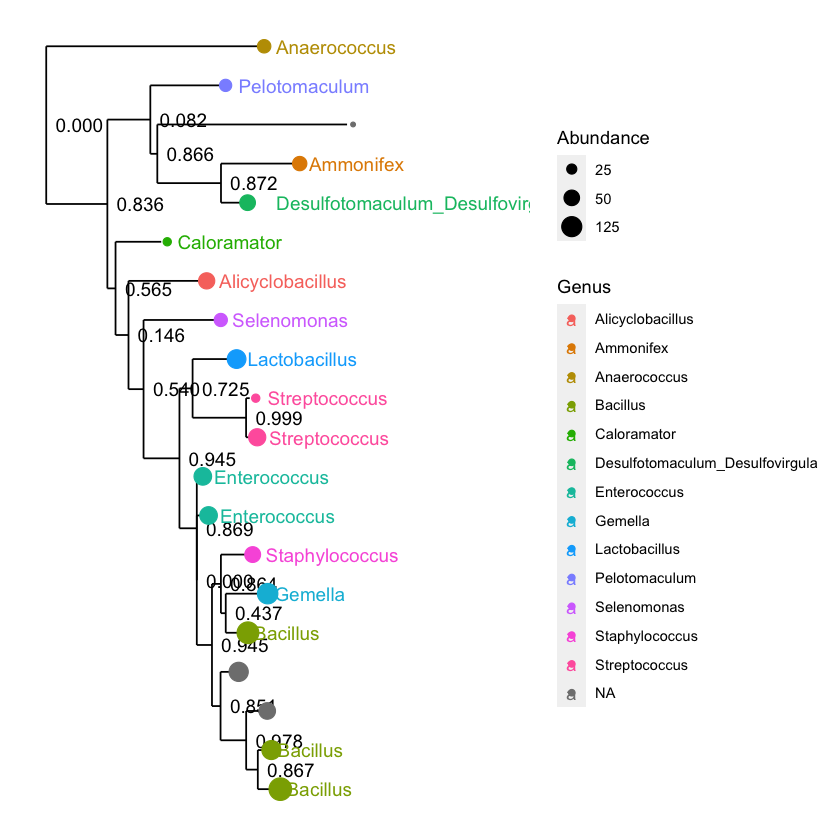

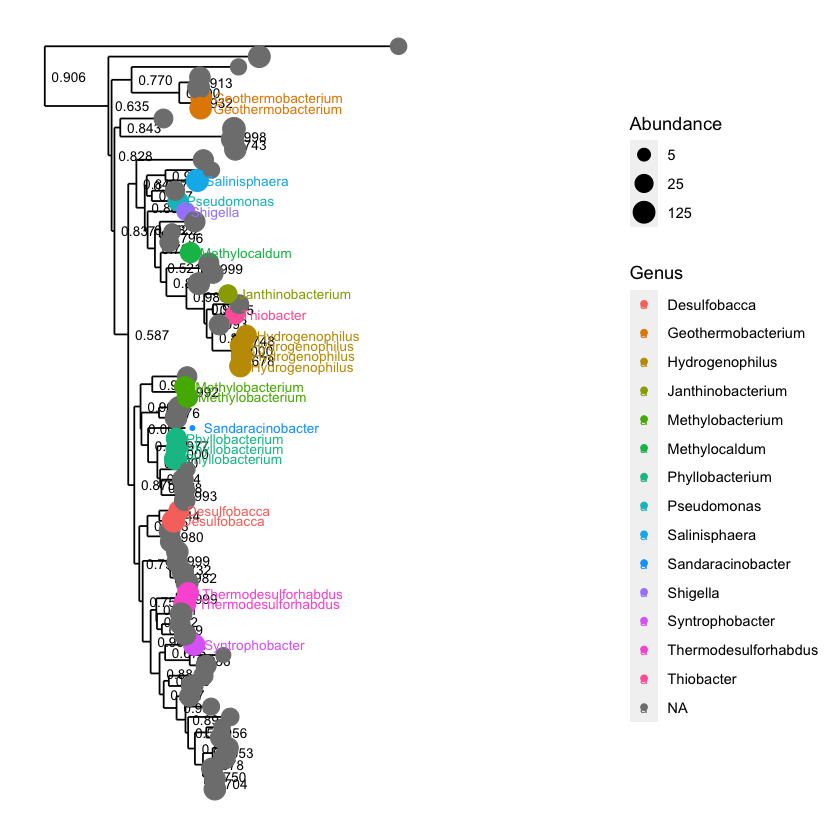

In [13]:
plot_tree(firmicutes, color = "Genus", label.tips = "Genus", size = "abundance", plot.margin = 0.5, ladderize=TRUE)
plot_tree(proteobacteria, color = "Genus", label.tips = "Genus", size = "abundance", plot.margin = 0.5, ladderize=TRUE)

We'll now take a look at our samples quantitatively by generating a barplot which includes taxonomic abundances.

In [14]:
OTUs <- read_qza("/Users/dgagler/School/BIOINFORMATICS/spirea_creek/q2_output/table-spireaM.qza")$data
taxonomy <- read_qza("/Users/dgagler/School/BIOINFORMATICS/spirea_creek/q2_output/taxonomy-spireaM.qza")$data %>% parse_taxonomy()

taxasums <- summarize_taxa(OTUs, taxonomy)$Phylum
taxa_barplot(taxasums)

ERROR: Error in read_qza("/Users/dgagler/School/BIOINFORMATICS/spirea_creek/q2_output/taxonomy-spireaM.qza")$data %>% : could not find function "%>%"


**Figure 3.** Barplot showing the taxonomic abundances in the data. The taxonomic abundances of 114M and 115M (Green Machine and Bubble Boy) are very similar, which is unsurprising given their similar temperature, pH, and appearance. Green Machine and Bubble Boy are also distinct from 112M (Heart of Joy) and 113M (Hat Stew). Note the enriched presence of Plantomycetes, Cyanobacteria, and Chloroflexi in Heart of Joy. Furthermore, note the significant abundance of Firmicutes, the enrichment of Actinobacteria, and the complete lack of Chloroflexi in 113M (Hat Stew). The results corroborate our previous alpha diversity analyses which showed significantly less diversity in Hat Stew.